In [1]:
import logging
from src.document import Document

pdf_path = "/home/jtt/Documents/datasets/gxd/5575588.pdf"
xpdf_base_path = "/home/jtt/Documents/outputs/xpdf"
data_path = "/home/jtt/Documents/outputs/debug"
log_path = "/home/jtt/Documents/outputs/debug/debug.log"

logging.basicConfig(
        filename=log_path,
        filemode="a",
        format="%(asctime)s - %(levelname)s - %(message)s",
        level=logging.INFO,
    )


In [2]:
document = Document(pdf_path, xpdf_base_path, data_path, include_first_page=False)

In [3]:
document.extract_figures()
document.draw(n_cols=5, txtr=True, save=True)

In [4]:
document.layout

Layout(width=595, height=793, num_cols=2, row_width=196, row_height=9, content_region=Bbox(x=42, y=15, width=502, height=741, x1=544, y1=756), col_coords=[42, 311])

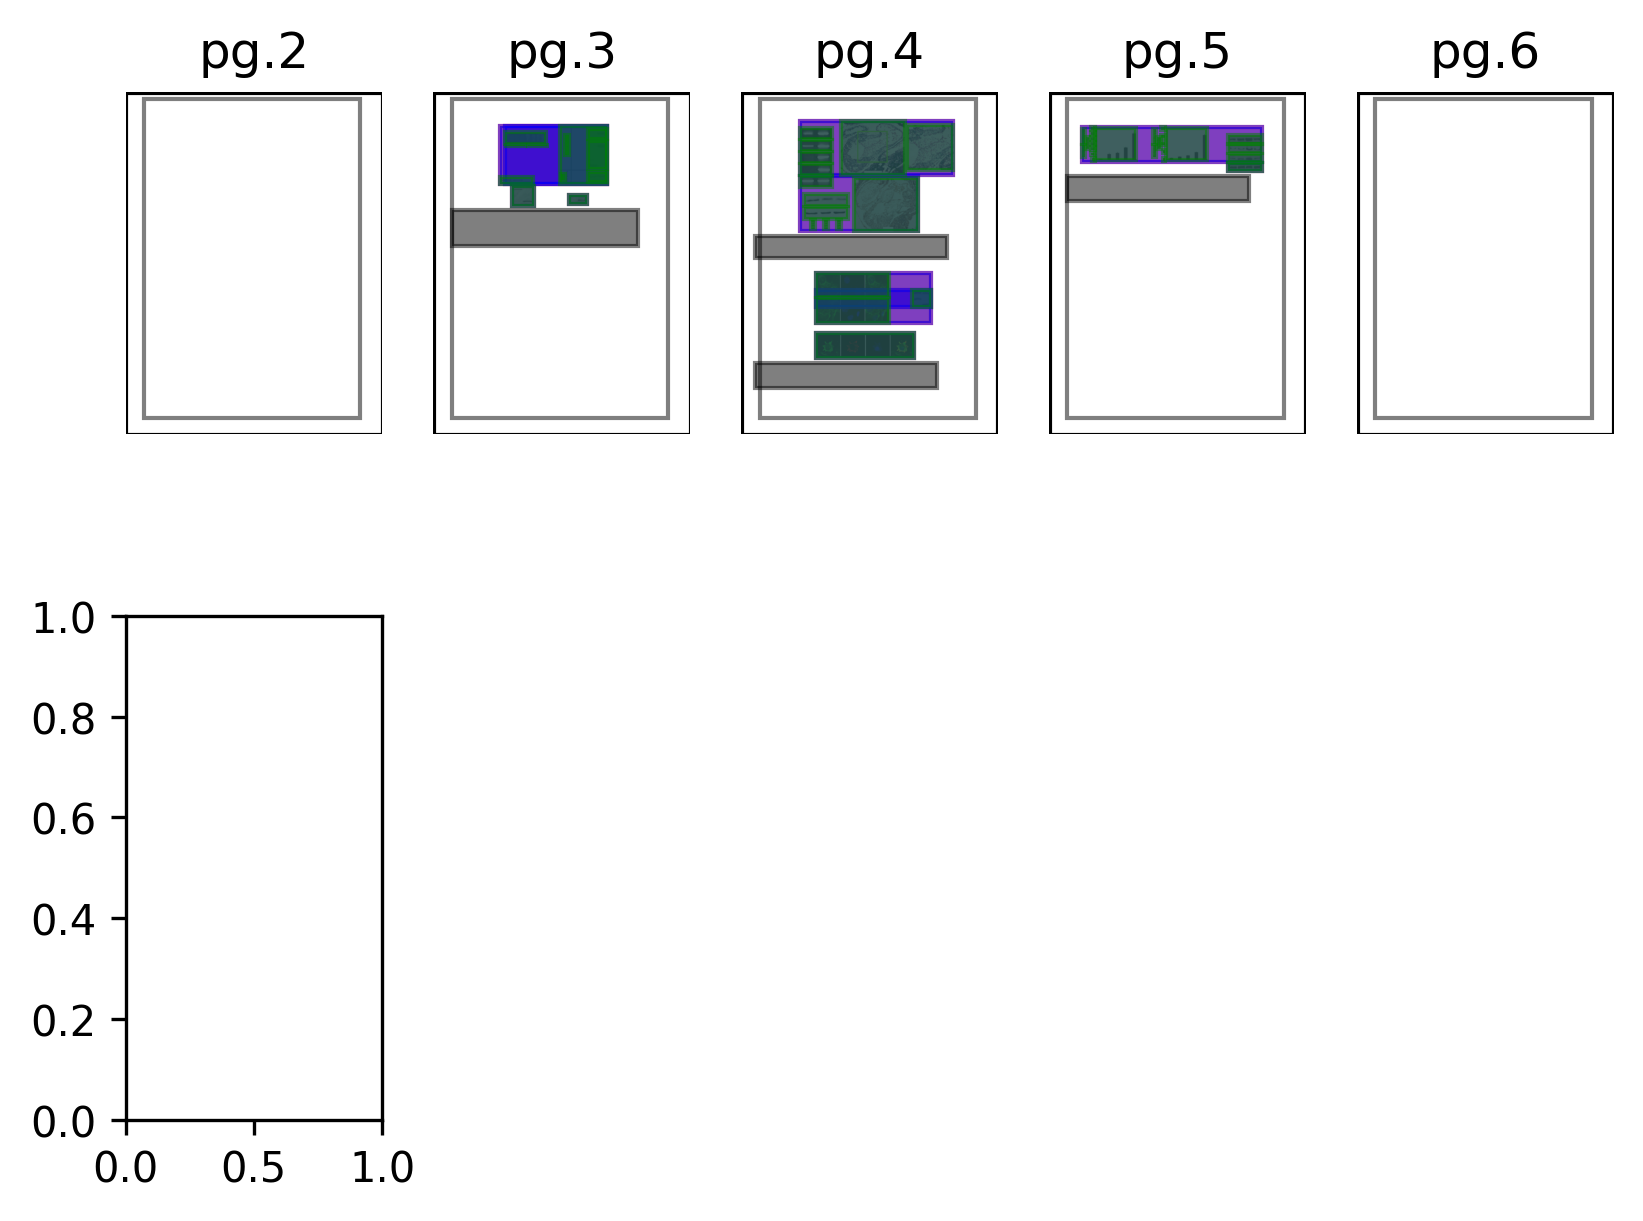

In [5]:
document.debug_candidates(n_cols=5)

In [7]:
page_num = 1
page = document.pages[page_num]
layout = document.layout
captions = document.pages[page_num].captions
base_folder_path = document.xpdf_path

(0.0, 1.0, 0.0, 1.0)

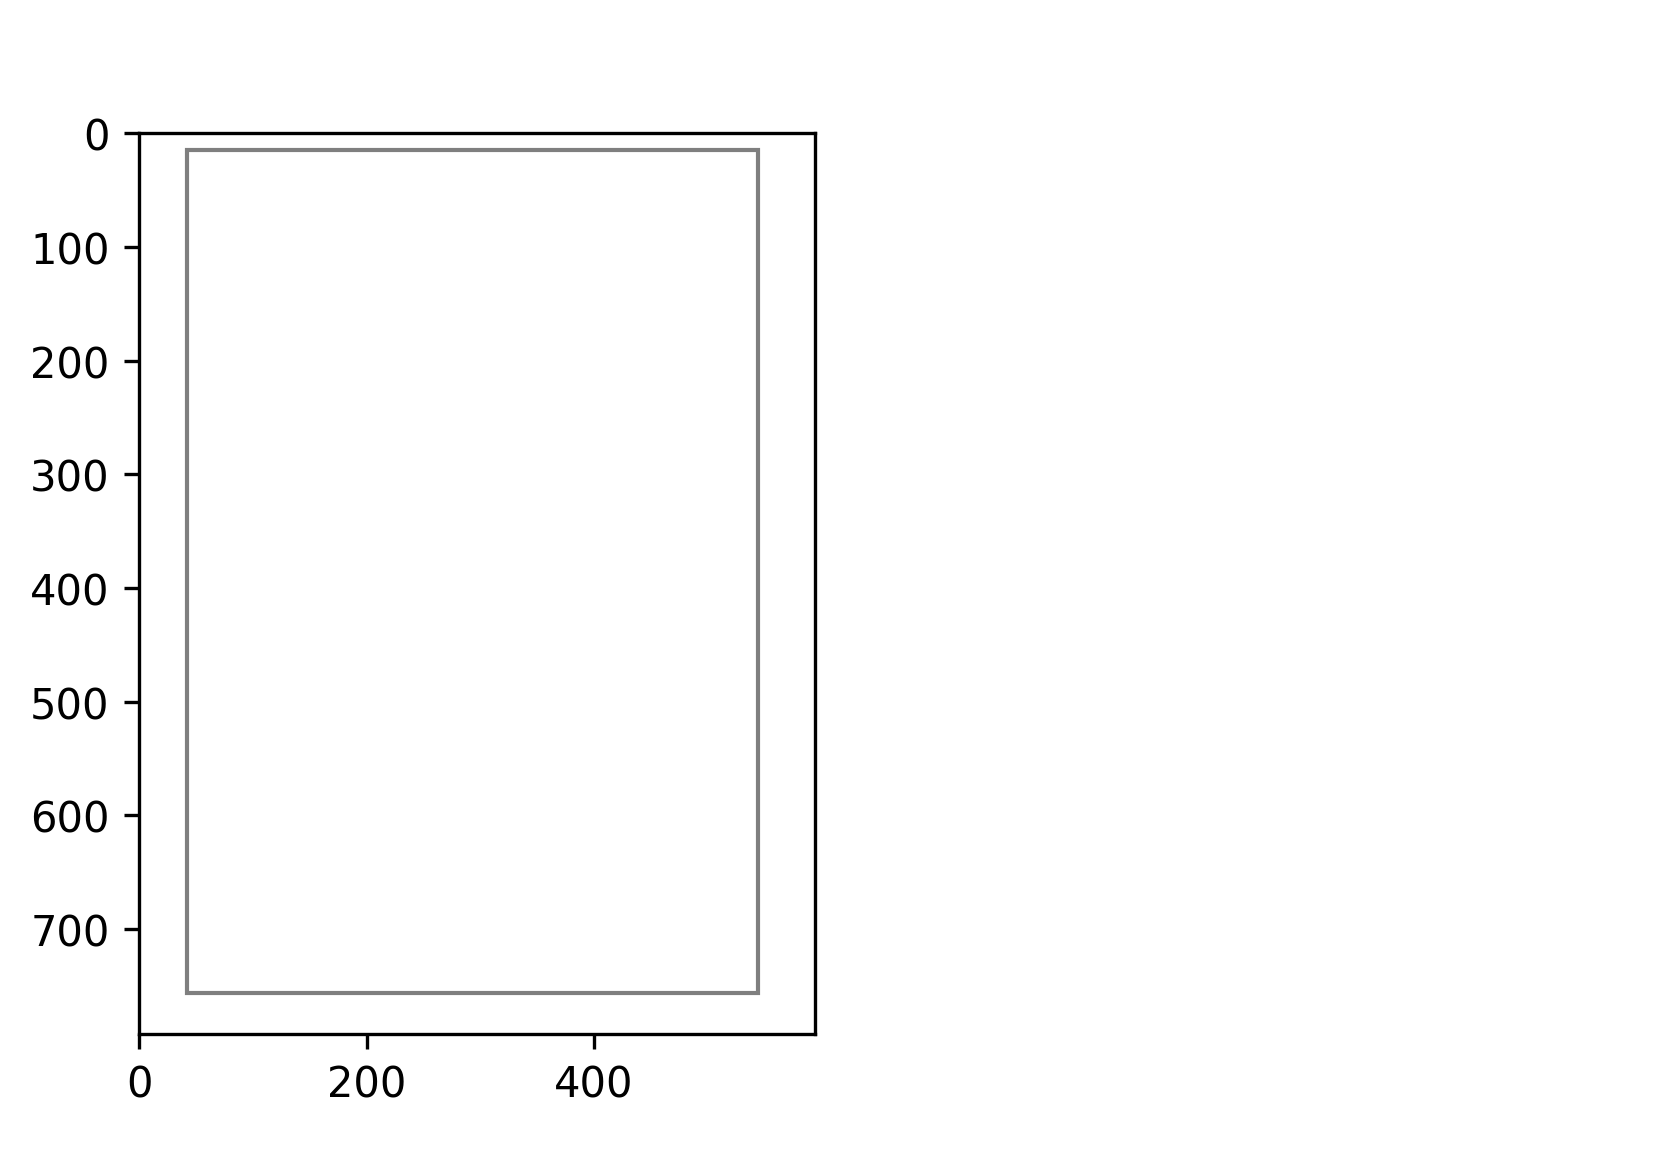

In [8]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from src.models import Bbox
from PIL import Image
from src.draw import draw_bboxes, draw_content_region
from src.utils import overlap_ratio_based

def calc_scaling_factor(image: cv2.Mat, page_width: int, page_height: int) -> float:
    # the PNG may be bigger than the html size
    height, width, _ = image.shape
    if height > width:
        return float(height) / page_height
    else:
        return float(width) / page_width

def scaled_bbox(cnt, scaling) -> Bbox:
    cnt_bbox = cv2.boundingRect(cnt)
    return Bbox(*[int(float(x) / scaling) for x in cnt_bbox])


png_path = str((Path(base_folder_path) / page.img_name).resolve())
page_image = cv2.imread(png_path)
page_image_gray = cv2.cvtColor(page_image, cv2.COLOR_BGR2GRAY)
scaling = calc_scaling_factor(page_image, page.width, page.height)

_, thresh = cv2.threshold(page_image_gray, 240, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations=1)
contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = [scaled_bbox(el, scaling) for el in contours]
cnts = [cnt for cnt in cnts if overlap_ratio_based(cnt, layout.content_region) > 0.75]

if layout.num_cols == 2:
    idxs_groups_merge = []
    x_cross = layout.col_coords[1]
    cr_width = layout.content_region.width
    cr_x = layout.content_region.x

    for i, cnt in enumerate(cnts):
        if cnt.x < x_cross and cnt.x1 > x_cross:
            idxs_merge = [i]
            for j, cnt_eval in enumerate(cnts):
                if cnt != cnt_eval:
                    row_region = Bbox(cr_x, cnt.y, cr_width, cnt.height)
                    if row_region.intersect_area(cnt_eval) > 0:
                        idxs_merge.append(j)
            if len(idxs_merge) > 1:
                idxs_groups_merge.append(idxs_merge)

    idxs_not_merge = [x for x in range(len(cnts))]
    affected_ids = [idx for group in idxs_groups_merge for idx in group]
    idxs_not_merge = set(idxs_not_merge).difference(set(affected_ids))

    merged_cnts = [cnts[i] for i in idxs_not_merge]
    for idxs_group in idxs_groups_merge:
        bboxes_to_merge = [cnts[i] for i in idxs_group]
        merged_cnts.append(Bbox.merge_bboxes(bboxes_to_merge))
    cnts = merged_cnts    

candidates = []
for cnt in cnts:
    if cnt.height > layout.row_height:
        candidates.append(cnt)

# draw
_, ax = plt.subplots(1, 2, dpi=300)
page_name = page.img_name
page_image = Image.open(png_path)
page_image = page_image.resize((page.width, page.height))
draw_bboxes(ax[0], candidates, edgecolor="red", facecolor="none", alpha=1.0)
draw_content_region(ax[0], document.layout.content_region)
ax[0].imshow(page_image)
ax[1].axis("off")


